# 2024/11/31 v1
# 2024/12/02 v2

Balanced class distribution after SMOTEENN: [65791 74077]


<Figure size 600x600 with 0 Axes>

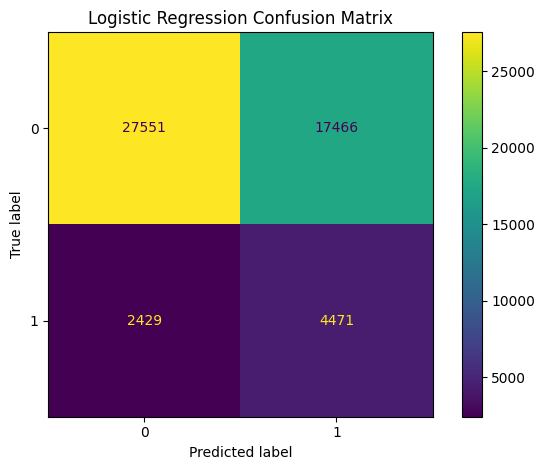

<Figure size 600x600 with 0 Axes>

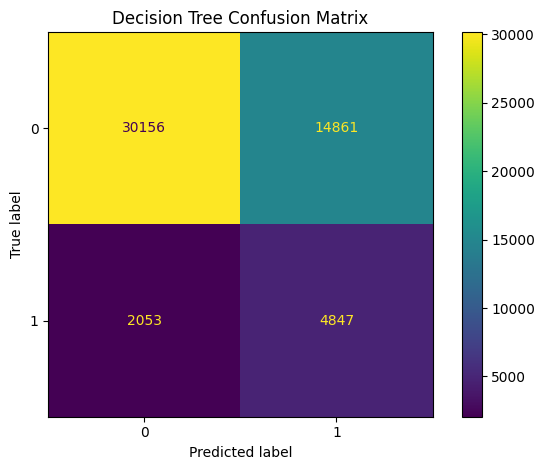

<Figure size 600x600 with 0 Axes>

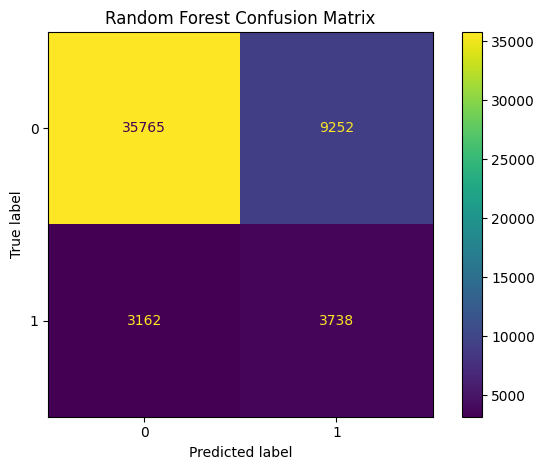

<Figure size 600x600 with 0 Axes>

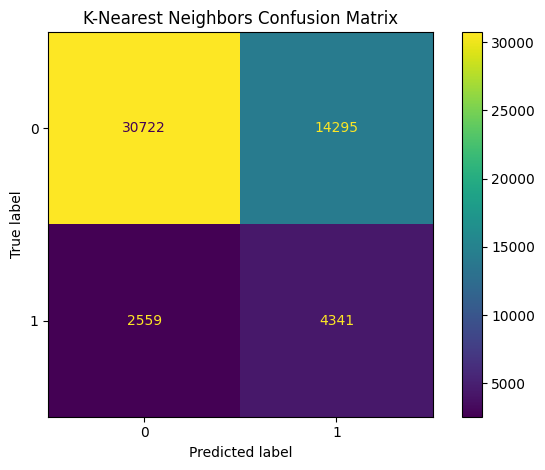

<Figure size 600x600 with 0 Axes>

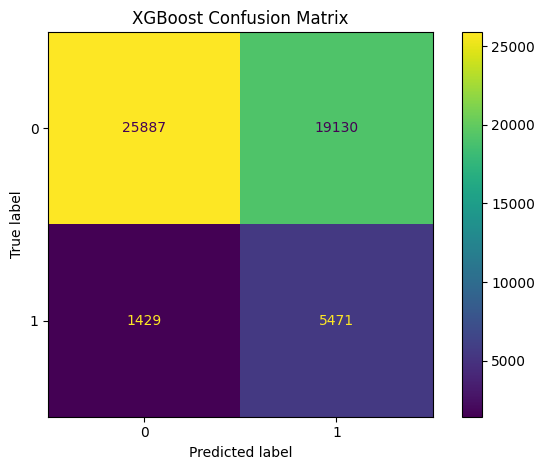

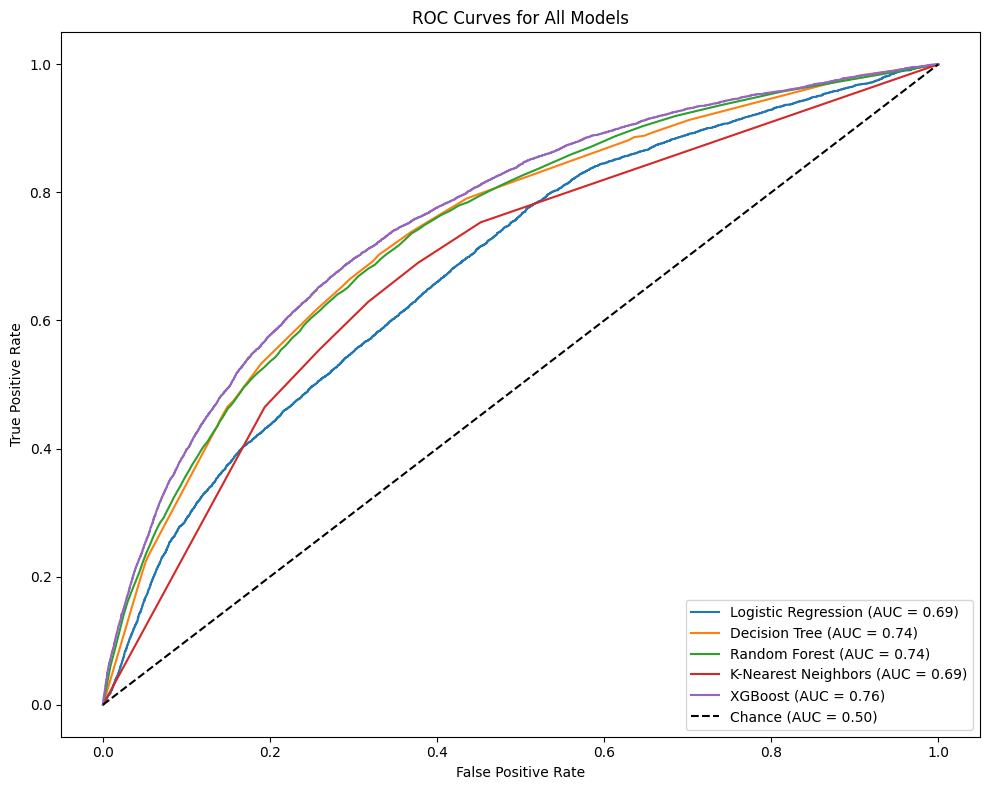

| Model               |   Precision |   Recall |   F1-Score |      AUC |   Cross-Validation Accuracy |
|:--------------------|------------:|---------:|-----------:|---------:|----------------------------:|
| Logistic Regression |    0.82393  | 0.616792 |   0.678287 | 0.686033 |                    0.700639 |
| Decision Tree       |    0.844514 | 0.674211 |   0.725605 | 0.739601 |                    0.794871 |
| Random Forest       |    0.834907 | 0.760888 |   0.78882  | 0.743158 |                    0.964867 |
| K-Nearest Neighbors |    0.831382 | 0.675366 |   0.725636 | 0.686708 |                    0.948673 |
| XGBoost             |    0.851291 | 0.604003 |   0.666808 | 0.76071  |                    0.861934 |


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Combine datasets
file_names = ['Crime_Incidents_in_2019.csv', 'Crime_Incidents_in_2020.csv',
              'Crime_Incidents_in_2021.csv', 'Crime_Incidents_in_2022.csv',
              'Crime_Incidents_in_2023.csv', 'Crime_Incidents_in_2024.csv']
datasets = [pd.read_csv(file) for file in file_names]

# Preprocess each dataset by dropping unnecessary columns
for data in datasets:
    data.drop(columns=['OCTO_RECORD_ID', 'BID', 'END_DATE'], inplace=True)

# Combine all datasets into one DataFrame
combined_data = pd.concat(datasets, ignore_index=True)

# Generate new features
combined_data['REPORT_DAT'] = pd.to_datetime(combined_data['REPORT_DAT'], errors='coerce')
combined_data['DayOfWeek'] = combined_data['REPORT_DAT'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
combined_data['Hour'] = combined_data['REPORT_DAT'].dt.hour  # Hour of the day
combined_data['IsWeekend'] = combined_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)  # Weekend indicator

# Define crime category for hotspots
violent_offenses = ['HOMICIDE', 'ASSAULT W/DANGEROUS WEAPON', 'ROBBERY']
combined_data['IsHotspot'] = combined_data['OFFENSE'].apply(lambda x: 1 if x in violent_offenses else 0)

# Select features and target variable
features = combined_data[['DayOfWeek', 'Hour', 'LATITUDE', 'LONGITUDE', 'IsWeekend']]
target = combined_data['IsHotspot']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Handle class imbalance using SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_balanced, y_train_balanced = smote_enn.fit_resample(X_train, y_train)
print("Balanced class distribution after SMOTEENN:", np.bincount(y_train_balanced))

# Define models
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', C=0.1, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(n_estimators=100, max_depth=7, scale_pos_weight=5, random_state=42)
}

# Initialize metrics collection
metrics = {
    "Model": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "AUC": [],
    "Cross-Validation Accuracy": []
}

# Evaluate models and plot individual confusion matrices
for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros(len(y_test))  # Probability predictions
    fpr, tpr, _ = roc_curve(y_test, y_prob)  # Compute ROC curve
    auc_score = auc(fpr, tpr) if hasattr(model, "predict_proba") else None
    scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')  # Cross-validation scores

    # Collect metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    metrics["Model"].append(name)
    metrics["Precision"].append(report['weighted avg']['precision'])
    metrics["Recall"].append(report['weighted avg']['recall'])
    metrics["F1-Score"].append(report['weighted avg']['f1-score'])
    metrics["AUC"].append(auc_score if auc_score is not None else "N/A")
    metrics["Cross-Validation Accuracy"].append(scores.mean())

    # Confusion matrix for each model
    plt.figure(figsize=(6, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='viridis', values_format='d')
    plt.title(f"{name} Confusion Matrix")
    plt.tight_layout()
    plt.show()

# Plot ROC curves (all models together)
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

# Add baseline
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Print metrics summary
metrics_df = pd.DataFrame(metrics)
print(metrics_df.to_markdown(index=False))


### The White House:
- Latitude: 38.8977
- Longitude: -77.0365
### Washington Monument:
- Latitude: 38.8895
- Longitude: -77.0353
### Smithsonian National Air and Space Museum:
- Latitude: 38.8882
- Longitude: -77.0199
### Dupont Circle:
- Latitude: 38.9096
- Longitude: -77.0434
### Union Station:
- Latitude: 38.8970
- Longitude: -77.0064

In [3]:
from geopy.geocoders import Nominatim

# Enhanced Prediction Function with Geocoding Support
def predict_safety_with_landmark():
    """
    Predict the safety of a given location and time using multiple machine learning models.
    The function supports Logistic Regression, Decision Tree, Random Forest, KNN, and XGBoost.
    Allows users to input a landmark instead of latitude and longitude.
    """
    geolocator = Nominatim(user_agent="crime_prediction")

    try:
        # Step 1: Get user input for location and time details
        landmark = input("Enter the name of the landmark or address: ")
        day_of_week = int(input("Enter the day of the week (0=Monday, 6=Sunday): "))
        hour = int(input("Enter the hour of the day (0-23): "))

        # Step 2: Geocode the landmark to get latitude and longitude
        location = geolocator.geocode(landmark)
        if not location:
            print(f"Could not find the location for '{landmark}'. Please try again.")
            return

        latitude = location.latitude
        longitude = location.longitude
        print(f"Geocoded location: {landmark} -> Latitude: {latitude}, Longitude: {longitude}")
    except ValueError:
        print("Invalid input. Please enter numeric values for day and hour.")
        return

    # Step 3: Process input data
    is_weekend = 1 if day_of_week >= 5 else 0  # Determine if it's a weekend
    input_data = pd.DataFrame([[day_of_week, hour, latitude, longitude, is_weekend]],
                              columns=['DayOfWeek', 'Hour', 'LATITUDE', 'LONGITUDE', 'IsWeekend'])

    # Standardize the features using the same scaler used during model training
    input_data_scaled = scaler.transform(input_data)

    # Fix for KNeighborsClassifier: Re-add feature names to the scaled data
    input_data_scaled_with_names = pd.DataFrame(input_data_scaled, columns=features.columns)

    # Step 4: Predict probabilities using each model
    logistic_probability = logistic_model.predict_proba(input_data_scaled)[0][1]
    tree_probability = tree_model.predict_proba(input_data_scaled)[0][1]
    rf_probability = rf_model.predict_proba(input_data_scaled)[0][1]
    knn_probability = knn_model.predict_proba(input_data_scaled_with_names)[0][1]
    xgb_probability = xgb_model.predict_proba(input_data_scaled)[0][1]

    # Step 5: Check if the location is historically marked as a hotspot
    is_hotspot = "Yes" if any(
        combined_data[
            (combined_data['DayOfWeek'] == day_of_week) & 
            (combined_data['Hour'] == hour) & 
            (combined_data['LATITUDE'].round(4) == round(latitude, 4)) & 
            (combined_data['LONGITUDE'].round(4) == round(longitude, 4))
        ]['IsHotspot'] == 1
    ) else "No"

    # Step 6: Output the results in a user-friendly format
    print("\n--- Safety Prediction ---")
    print(f"Location: {landmark} ({latitude}, {longitude})")
    print(f"Day of Week: {day_of_week} ({'Weekend' if is_weekend else 'Weekday'}), Hour: {hour}:00")
    print(f"Is Hotspot (based on historical data): {is_hotspot}")
    print("\nPredictions and probabilities (Dangerous Possibility):")
    print(f"Logistic Regression: {'Dangerous' if logistic_probability >= 0.5 else 'Safe'} ({logistic_probability:.2f})")
    print(f"Decision Tree: {'Dangerous' if tree_probability >= 0.5 else 'Safe'} ({tree_probability:.2f})")
    print(f"Random Forest: {'Dangerous' if rf_probability >= 0.5 else 'Safe'} ({rf_probability:.2f})")
    print(f"K-Nearest Neighbors: {'Dangerous' if knn_probability >= 0.5 else 'Safe'} ({knn_probability:.2f})")
    print(f"XGBoost: {'Dangerous' if xgb_probability >= 0.5 else 'Safe'} ({xgb_probability:.2f})")

# Run the prediction function
logistic_model = LogisticRegression(class_weight='balanced', C=0.1, random_state=42)
logistic_model.fit(X_train_balanced, y_train_balanced)

tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train_balanced, y_train_balanced)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_balanced, y_train_balanced)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_balanced, y_train_balanced)

xgb_model = XGBClassifier(n_estimators=100, max_depth=7, scale_pos_weight=5, random_state=42)
xgb_model.fit(X_train_balanced, y_train_balanced)
predict_safety_with_landmark()


Enter the name of the landmark or address: white house
Enter the day of the week (0=Monday, 6=Sunday): 1
Enter the hour of the day (0-23): 23
Geocoded location: white house -> Latitude: 38.897699700000004, Longitude: -77.03655315

--- Safety Prediction ---
Location: white house (38.897699700000004, -77.03655315)
Day of Week: 1 (Weekday), Hour: 23:00
Is Hotspot (based on historical data): No

Predictions and probabilities (Dangerous Possibility):
Logistic Regression: Safe (0.15)
Decision Tree: Safe (0.27)
Random Forest: Safe (0.04)
K-Nearest Neighbors: Safe (0.00)
XGBoost: Safe (0.32)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
